# Chapter 15: Agent Frameworks - Practical Implementations

This notebook contains the code examples for the **CrewAI** and **LangGraph** implementations of the Loan Processing Agent, as discussed in Chapter 15.

We will build the same multi-step workflow in both frameworks to compare their different abstractions and approaches. This version is configured to use **Google's Gemini** model.

In [1]:
#@title Install dependencies

!pip install --upgrade crewai crewai_tools langchain-google-genai langgraph langchain-core -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 4.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.9/67.9 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 631.5/631.5 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.1/755.1 kB 35.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.6/55.6 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.8/156.8 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.9/471.9 kB 21.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.9/19.9 MB 83.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 61.0 MB/s

In [ ]:
#@title 1. Configure your API Key

# Option 1: Use Google Colab Secrets (recommended for Colab)
import os
try:
    from google.colab import userdata
    os.environ["GOOGLE_API_KEY"] = userdata.get('GOOGLE_API_KEY')
    print("API Key loaded from Colab secrets.")
except ImportError:
    # Option 2: Use python-dotenv (recommended for local)
    # Create a .env file in the same directory with: GOOGLE_API_KEY=your_key_here
    from dotenv import load_dotenv
    if load_dotenv():
        print("API Key loaded from .env file.")
    else:
        # Option 3: Set directly (less secure, use only for temporary testing)
        # Replace "your_api_key_here" with your actual key if using this method
        # os.environ["GOOGLE_API_KEY"] = "your_api_key_here"
        # print("Attempted to load API Key directly (ensure it's set if not using secrets/.env).")
        print("API Key not found via Colab secrets or .env file. Please ensure it's set.")

# Check if the key is actually set
if not os.getenv("GOOGLE_API_KEY"):
    print("\nWARNING: GOOGLE_API_KEY environment variable not set. LLM calls will likely fail.")

API Key loaded from Colab secrets.


In [ ]:
#@title Imports and LLM Configuration

import os
import json
from getpass import getpass

from crewai import Agent, Task, Crew, Process, LLM
from crewai.tools import BaseTool
from langchain_google_genai import ChatGoogleGenerativeAI

from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser


# --- Initialize the LLM ---
# We'll use one Gemini instance for all examples
# First we'll instantiate the llm for CrewAI
try:

    llm = LLM(
    model='gemini/gemini-2.5-flash',
    api_key=os.getenv("GOOGLE_API_KEY"),
    temperature=0.0  # Lower temperature for more consistent results.
)
    print(f"LLM ({llm.model}) configured.")
except Exception as e:
    print(f"Error initializing LLM: {e}")
    print("Ensure your GOOGLE_API_KEY is set correctly and you have the necessary permissions.")
    llm = None # Set llm to None if initialization fails

# Define a new LLM just for LangGraph
try:
    lg_llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash")
    print("LangGraph-specific LLM (lg_llm) initialized.")
except Exception as e:
    print(f"Error initializing LangGraph LLM: {e}")
    lg_llm = None

LLM (gemini/gemini-2.5-flash) configured.
LangGraph-specific LLM (lg_llm) initialized.


## Common Tools Definition

First, we define the common set of Python functions that our agents will use as tools. Both frameworks will use these same tools. These represent our core business logic.

In [ ]:
# --- Define Tool Classes inheriting from BaseTool ---

class ValidateDocumentFieldsTool(BaseTool):
    name: str = "Validate Document Fields"
    description: str = (
        "Validates that the loan application (a JSON string) contains all required fields."
    )

    def _run(self, application_data: str) -> str:
        """Validates the application data."""
        print(f"--- TOOL: Validating document fields ---")
        try:
            data = json.loads(application_data)
            required_fields = ["customer_id", "loan_amount", "income", "credit_history"]
            missing_fields = [field for field in required_fields if field not in data]
            if missing_fields:
                return json.dumps({"error": f"Validation failed: Missing required fields: {', '.join(missing_fields)}"})
            # Return the original data if valid
            return json.dumps({"status": "validated", "data": data})
        except json.JSONDecodeError:
            return json.dumps({"error": "Invalid JSON format in application data."})

class QueryCreditBureauAPITool(BaseTool):
    name: str = "Query Credit Bureau API"
    description: str = (
        "Simulates a call to a credit bureau API to retrieve a credit score given a customer_id."
    )

    def _run(self, customer_id: str) -> str:
        """Queries the mock credit bureau."""
        print(f"--- TOOL: Calling Credit Bureau API for customer: {customer_id} ---")

        # --- FIX: Added CUST-12345 and CUST-55555 ---
        mock_credit_scores = {
            "CUST-12345": 810,  # Happy Path
            "CUST-55555": 620,  # High Risk Path
            "borrower_good_780": 810, # Kept your old ones
            "borrower_bad_620": 620
        }
        score = mock_credit_scores.get(customer_id)

        if score is not None:
            return json.dumps({"customer_id": customer_id, "credit_score": score})
        return json.dumps({"error": "Customer ID not found."})

class CalculateRiskScoreTool(BaseTool):
    name: str = "Calculate Risk Score"
    description: str = (
        "Calculates a risk score based on loan_amount, income, and credit_score."
    )

    def _run(self, loan_amount: int, income: str, credit_score: int) -> str:
        """Calculates the risk score."""
        print(f"--- TOOL: Calculating risk score ---")
        try:
            income_value = int(''.join(filter(str.isdigit, income)))
            annual_income = income_value * 12 if "month" in income.lower() else income_value
        except (ValueError, TypeError):
            annual_income = 0

        if annual_income == 0:
            risk_score = 10
        else:
            loan_to_income_ratio = loan_amount / annual_income
            risk_score = 1
            if credit_score < 650:
                risk_score += 4
            elif credit_score < 720:
                risk_score += 2
            if loan_to_income_ratio > 0.8:
                risk_score += 5
            elif loan_to_income_ratio > 0.5:
                risk_score += 2
        return json.dumps({"risk_score": min(risk_score, 10)})

class CheckLendingComplianceTool(BaseTool):
    name: str = "Check Lending Compliance"
    description: str = (
        "Checks the application against internal policies using credit_history and risk_score."
    )

    def _run(self, credit_history: str, risk_score: int) -> str:
        """Checks compliance rules."""
        print(f"--- TOOL: Checking compliance rules (including risk score) ---")
        if credit_history == "No History":
            return json.dumps({"is_compliant": False, "reason": "Policy violation: No credit history is an automatic denial."})
        if risk_score >= 8:
            return json.dumps({"is_compliant": False, "reason": f"Policy violation: Risk score of {risk_score} is too high for approval."})
        return json.dumps({"is_compliant": True, "reason": "Application meets all internal policy guidelines."})

# --- Instantiate the Tools ---
validate_document_fields_tool = ValidateDocumentFieldsTool()
query_credit_bureau_api_tool = QueryCreditBureauAPITool()
calculate_risk_score_tool = CalculateRiskScoreTool()
check_lending_compliance_tool = CheckLendingComplianceTool()

In [ ]:
#@title Helper Functions

# --- Helper Function for Mock Data ---

def get_document_content(document_id: str) -> str:
    """
    Simulates fetching document content based on its ID.

    FIX: This now returns a JSON STRING to match the
    ValidateDocumentFieldsTool's expectations.
    """
    print(f"--- HELPER: Simulating fetch for doc_id: {document_id} ---")
    if document_id == "document_valid_123":
        # Represents a valid, complete application
        data = {
            "customer_id": "CUST-12345", # Use an ID that will be in the credit tool
            "loan_amount": 50000,
            "income": "USD 120000 a year",
            "credit_history": "7 years"
        }
        return json.dumps(data)

    elif document_id == "document_invalid_456":
        # Represents an invalid, incomplete application (missing income)
        data = {
            "customer_id": "CUST-55555", # Use an ID that will be in the credit tool
            "loan_amount": 200000,
            # "income" is missing
            "credit_history": "1 year"
        }
        return json.dumps(data) # This will now fail validation for 'income'

    else:
        return json.dumps({"error": "Document ID not found."})

# Implementation 1: CrewAI (The Collaborative Team)

CrewAI's philosophy is centered on **role-playing agents** that form a "crew." We will create one agent for each of our tools and a final "manager" agent to assemble the report.

### Step 1: Define the Agents

In [ ]:
# 1. Document Validation Agent
doc_specialist = Agent(
    role="Document Validation Specialist",
    goal="Validate the completeness and format of a new loan application provided as a JSON string.",
    backstory=(
        "You are a meticulous agent responsible for the first step of loan processing. "
        "Your sole task is to receive a JSON string, call the `Validate Document Fields` tool, "
        "and return its exact JSON output. You do not talk to the user or other agents."
    ),
    tools=[validate_document_fields_tool],
    llm=llm,
    allow_delegation=False,
    verbose=True
)

# 2. Credit Check Agent
credit_analyst = Agent(
    role="Credit Check Agent",
    goal="Query the credit bureau API to retrieve an applicant's credit score.",
    backstory=(
        "You are a specialized agent that interacts with the Credit Bureau. "
        "Your sole task is to receive a `customer_id`, call the `Query Credit Bureau API` tool, "
        "and return its exact JSON output."
    ),
    tools=[query_credit_bureau_api_tool],
    llm=llm,
    allow_delegation=False,
    verbose=True
)

# 3. Risk Assessment Agent
risk_assessor = Agent(
    role="Risk Assessment Analyst",
    goal="Calculate the financial risk score for a loan application.",
    backstory=(
        "You are a quantitative analyst agent. Your sole task is to receive `loan_amount`, `income`, and `credit_score`, "
        "call the `Calculate Risk Score` tool, and return its exact JSON output."
    ),
    tools=[calculate_risk_score_tool],
    llm=llm,
    allow_delegation=False,
    verbose=True
)

# 4. Compliance Agent
compliance_officer = Agent(
    role="Compliance Officer",
    goal="Check the application against all internal lending policies and compliance rules.",
    backstory=(
        "You are the final checkpoint for policy and compliance. Your sole task is to receive `credit_history` and `risk_score`, "
        "call the `CheckLendingCompliance` tool, and return its exact JSON output."
    ),
    tools=[check_lending_compliance_tool],
    llm=llm,
    allow_delegation=False,
    verbose=True
)

# 5. Manager Agent (for the final report)
manager = Agent(
    role="Loan Processing Manager",
    goal="Manage the loan application workflow and compile the final report.",
    backstory=(
        "You are the manager responsible for orchestrating the "
        "loan processing pipeline, ensuring data flows correctly, and formulating the "
        "final decision and report based on your team's findings."
    ),
    llm=llm,
    allow_delegation=True, # The manager can delegate to the team
    verbose=True
)

print("Agents (doc_specialist, credit_analyst, etc.) defined successfully!")

Agents (doc_specialist, credit_analyst, etc.) defined successfully!

### Step 2: Define the Tasks

Notice how we use `context` to implicitly pass the output of previous tasks to the next agents in the sequence. We also define the input data here.

In [ ]:
#@title 1.2: Define CrewAI Tasks

# Define two sets of input data for testing
loan_application_inputs_valid = {
    "applicant_id": "borrower_good_780", # This ID is now descriptive, not functional
    "document_id": "document_valid_123"
}

loan_application_inputs_invalid = {
    "applicant_id": "borrower_bad_620",
    "document_id": "document_invalid_456"
}

if llm is None:
    print("LLM not initialized. Skipping Task definition.")
else:
    # Task 1: Validate Document Content
    task_validate = Task(
        description=(
            "Validate the loan application, which is provided as a JSON string: '{document_content}'. "
            "You MUST pass this entire JSON string directly to the 'Validate Document Fields' tool."
        ),
        expected_output="A JSON string with the validation status and all extracted data ('status': '...', 'data': {...}).",
        agent=doc_specialist
    )

    # Task 2: Check Credit
    task_credit = Task(
        description=(
            "1. Parse the JSON output from the validation task. \n"
            "2. Extract the `customer_id` from its 'data' field. \n"
            "3. Call the `Query Credit Bureau API` tool with this `customer_id`."
        ),
        expected_output="A JSON string containing the customer_id and their credit_score.",
        agent=credit_analyst,
        context=[task_validate] # Depends on task_validate
    )

    # Task 3: Assess Risk
    task_risk = Task(
        description=(
            "1. Parse the JSON output from the validation task to get `loan_amount` and `income`. \n"
            "2. Parse the JSON output from the credit check task to get `credit_score`. \n"
            "3. Call the `Calculate Risk Score` tool with these three values."
        ),
        expected_output="A JSON string containing the calculated risk_score.",
        agent=risk_assessor,
        context=[task_validate, task_credit] # Depends on two tasks
    )

    # Task 4: Check Compliance
    task_compliance = Task(
        description=(
            "1. Parse the JSON output from the validation task to get `credit_history`. \n"
            "2. Parse the JSON output from the risk assessment task to get `risk_score`. \n"
            "3. Call the `Check Lending Compliance` tool with these two values."
        ),
        expected_output="A JSON string with the compliance status (is_compliant: true/false) and a reason.",
        agent=compliance_officer,
        context=[task_validate, task_risk] # Depends on two tasks
    )

    # Task 5: Compile Final Report (Updated to use hierarchical manager)
    task_report = Task(
        description=(
            "Compile a final loan decision report synthesizing all findings from the previous tasks. "
            "The report must include: \n"
            "- The final decision (Approve/Deny). \n"
            "- A clear justification for the decision, referencing the validation status, "
            "credit score, risk score, and compliance check."
        ),
        expected_output="A comprehensive final report in Markdown format.",
        agent=manager,
        context=[task_validate, task_credit, task_risk, task_compliance] # Depends on all tasks
    )
    print("CrewAI Tasks defined successfully!")

CrewAI Tasks defined successfully!

### Step 3: Assemble and Run the Crew

In [ ]:
#@title 1.3: Assemble and Run the Crew (FIXED)
if llm is None:
    print("LLM not initialized. Skipping Crew execution.")
else:
    # Assemble the crew
    loan_crew = Crew(
        agents=[doc_specialist, credit_analyst, risk_assessor, compliance_officer], # Manager is assigned below
        tasks=[task_validate, task_credit, task_risk, task_compliance, task_report],
        process=Process.hierarchical, # Use Hierarchical process
        manager_agent=manager, # Assign the manager
        verbose=True # Use True instead of 2
    )

    # --- Run with VALID inputs ---
    print("--- KICKING OFF CREWAI PROCESS (VALID INPUTS) ---")

    # Get the JSON content from the helper
    valid_json_content = get_document_content(loan_application_inputs_valid['document_id'])

    inputs_valid = {
        # This key 'document_content' MUST match the placeholder in task_validate
        'document_content': valid_json_content
    }

    result_valid = loan_crew.kickoff(inputs=inputs_valid)
    print("\n\n--- CREWAI FINAL REPORT (VALID) ---")
    print(result_valid)

    # --- Run with INVALID inputs ---
    print("\n\n--- KICKING OFF CREWAI PROCESS (INVALID INPUTS) ---")

    # Get the JSON content from the helper
    invalid_json_content = get_document_content(loan_application_inputs_invalid['document_id'])

    inputs_invalid = {
        'document_content': invalid_json_content
    }

    result_invalid = loan_crew.kickoff(inputs=inputs_invalid)
    print("\n\n--- CREWAI FINAL REPORT (INVALID) ---")
    print(result_invalid)

--- KICKING OFF CREWAI PROCESS (VALID INPUTS) ---

--- HELPER: Simulating fetch for doc_id: document_valid_123 ---

╭──────────────────────────────────────────── Crew Execution Started ─────────────────────────────────────────────╮
│                                                                                                                 │
│  Crew Execution Started                                                                                         │
│  Name: crew                                                                                                     │
│  ID: 2fe08b83-fb39-4060-892b-0b6a80b0f29a                                                                       │
│  Tool Args:                                                                                                     │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────── 🤖 Agent Started ────────────────────────────────────────────────╮
│                                                                                                                 │
│  Agent: Loan Processing Manager                                                                                 │
│                                                                                                                 │
│  Task: Validate the loan application, which is provided as a JSON string: '{"customer_id": "CUST-12345",        │
│  "loan_amount": 50000, "income": "USD 120000 a year", "credit_history": "7 years"}'. You MUST pass this entire  │
│  JSON string directly to the 'Validate Document Fields' tool.                                                   │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

--- TOOL: Validating document fields ---

╭──────────────────────────────────────────── 🔧 Agent Tool Execution ────────────────────────────────────────────╮
│                                                                                                                 │
│  Agent: Loan Processing Manager                                                                                 │
│                                                                                                                 │
│  Thought: Action: Validate Document Fields                                                                      │
│                                                                                                                 │
│  Using Tool: Validate Document Fields                                                                           │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────────────────────── Tool Input ───────────────────────────────────────────────────╮
│                                                                                                                 │
│  "{\"application_data\": \"{\\\"customer_id\\\": \\\"CUST-12345\\\", \\\"loan_amount\\\": 50000, \\\"income\\\  │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────────────────────── Tool Output ──────────────────────────────────────────────────╮
│                                                                                                                 │
│  {"status": "validated", "data": {"customer_id": "CUST-12345", "loan_amount": 50000, "income": "USD 120000 a    │
│  year", "credit_history": "7 years"}}                                                                           │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Output()

╭───────────────────────────────────────────── ✅ Agent Final Answer ─────────────────────────────────────────────╮
│                                                                                                                 │
│  Agent: Loan Processing Manager                                                                                 │
│                                                                                                                 │
│  Final Answer:                                                                                                  │
│  {"status": "validated", "data": {"customer_id": "CUST-12345", "loan_amount": 50000, "income": "USD 120000 a    │
│  year", "credit_history": "7 years"}}                                                                           │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── Task Completion ────────────────────────────────────────────────╮
│                                                                                                                 │
│  Task Completed                                                                                                 │
│  Name: 8cfca2ea-b2cb-4517-b85a-5802bb1a03c7                                                                     │
│  Agent: Loan Processing Manager                                                                                 │
│  Tool Args:                                                                                                     │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────── 🤖 Agent Started ────────────────────────────────────────────────╮
│                                                                                                                 │
│  Agent: Loan Processing Manager                                                                                 │
│                                                                                                                 │
│  Task: 1. Parse the JSON output from the validation task.                                                       │
│  2. Extract the `customer_id` from its 'data' field.                                                            │
│  3. Call the `Query Credit Bureau API` tool with this `customer_id`.                                            │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Output()

--- TOOL: Calling Credit Bureau API for customer: CUST-12345 ---

╭──────────────────────────────────────────── 🔧 Agent Tool Execution ────────────────────────────────────────────╮
│                                                                                                                 │
│  Agent: Loan Processing Manager                                                                                 │
│                                                                                                                 │
│  Thought: Action: Query Credit Bureau API                                                                       │
│                                                                                                                 │
│  Using Tool: Query Credit Bureau API                                                                            │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────────────────────── Tool Input ───────────────────────────────────────────────────╮
│                                                                                                                 │
│  "{\"customer_id\": \"CUST-12345\"}"                                                                            │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────────────────────── Tool Output ──────────────────────────────────────────────────╮
│                                                                                                                 │
│  {"customer_id": "CUST-12345", "credit_score": 810}                                                             │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Output()

╭───────────────────────────────────────────── ✅ Agent Final Answer ─────────────────────────────────────────────╮
│                                                                                                                 │
│  Agent: Loan Processing Manager                                                                                 │
│                                                                                                                 │
│  Final Answer:                                                                                                  │
│  {"customer_id": "CUST-12345", "credit_score": 810}                                                             │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── Task Completion ────────────────────────────────────────────────╮
│                                                                                                                 │
│  Task Completed                                                                                                 │
│  Name: 86bdbba1-cd35-4907-b3f1-1dfacd6252d5                                                                     │
│  Agent: Loan Processing Manager                                                                                 │
│  Tool Args:                                                                                                     │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────── 🤖 Agent Started ────────────────────────────────────────────────╮
│                                                                                                                 │
│  Agent: Loan Processing Manager                                                                                 │
│                                                                                                                 │
│  Task: 1. Parse the JSON output from the validation task to get `loan_amount` and `income`.                     │
│  2. Parse the JSON output from the credit check task to get `credit_score`.                                     │
│  3. Call the `Calculate Risk Score` tool with these three values.                                               │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Output()

--- TOOL: Calculating risk score ---

╭──────────────────────────────────────────── 🔧 Agent Tool Execution ────────────────────────────────────────────╮
│                                                                                                                 │
│  Agent: Loan Processing Manager                                                                                 │
│                                                                                                                 │
│  Thought: Action: Calculate Risk Score                                                                          │
│                                                                                                                 │
│  Using Tool: Calculate Risk Score                                                                               │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────────────────────── Tool Input ───────────────────────────────────────────────────╮
│                                                                                                                 │
│  "{\"loan_amount\": 50000, \"income\": \"USD 120000 a year\", \"credit_score\": 810}"                           │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────────────────────── Tool Output ──────────────────────────────────────────────────╮
│                                                                                                                 │
│  {"risk_score": 1}                                                                                              │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Output()

╭───────────────────────────────────────────── ✅ Agent Final Answer ─────────────────────────────────────────────╮
│                                                                                                                 │
│  Agent: Loan Processing Manager                                                                                 │
│                                                                                                                 │
│  Final Answer:                                                                                                  │
│  {"risk_score": 1}                                                                                              │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── Task Completion ────────────────────────────────────────────────╮
│                                                                                                                 │
│  Task Completed                                                                                                 │
│  Name: d62066ca-41d4-426f-99c9-7d3394cdd4e9                                                                     │
│  Agent: Loan Processing Manager                                                                                 │
│  Tool Args:                                                                                                     │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────── 🤖 Agent Started ────────────────────────────────────────────────╮
│                                                                                                                 │
│  Agent: Loan Processing Manager                                                                                 │
│                                                                                                                 │
│  Task: 1. Parse the JSON output from the validation task to get `credit_history`.                               │
│  2. Parse the JSON output from the risk assessment task to get `risk_score`.                                    │
│  3. Call the `Check Lending Compliance` tool with these two values.                                             │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Output()

--- TOOL: Checking compliance rules (including risk score) ---

╭──────────────────────────────────────────── 🔧 Agent Tool Execution ────────────────────────────────────────────╮
│                                                                                                                 │
│  Agent: Loan Processing Manager                                                                                 │
│                                                                                                                 │
│  Thought: Action: Check Lending Compliance                                                                      │
│                                                                                                                 │
│  Using Tool: Check Lending Compliance                                                                           │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────────────────────── Tool Input ───────────────────────────────────────────────────╮
│                                                                                                                 │
│  "{\"credit_history\": \"7 years\", \"risk_score\": 1}"                                                         │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────────────────────── Tool Output ──────────────────────────────────────────────────╮
│                                                                                                                 │
│  {"is_compliant": true, "reason": "Application meets all internal policy guidelines."}                          │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Output()

╭───────────────────────────────────────────── ✅ Agent Final Answer ─────────────────────────────────────────────╮
│                                                                                                                 │
│  Agent: Loan Processing Manager                                                                                 │
│                                                                                                                 │
│  Final Answer:                                                                                                  │
│  {"is_compliant": true, "reason": "Application meets all internal policy guidelines."}                          │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── Task Completion ────────────────────────────────────────────────╮
│                                                                                                                 │
│  Task Completed                                                                                                 │
│  Name: b0b5ccb0-1e24-4e14-a173-500e063fc7c7                                                                     │
│  Agent: Loan Processing Manager                                                                                 │
│  Tool Args:                                                                                                     │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────── 🤖 Agent Started ────────────────────────────────────────────────╮
│                                                                                                                 │
│  Agent: Loan Processing Manager                                                                                 │
│                                                                                                                 │
│  Task: Compile a final loan decision report synthesizing all findings from the previous tasks. The report must  │
│  include:                                                                                                       │
│  - The final decision (Approve/Deny).                                                                           │
│  - A clear justification for the decision, referencing the validation status, credit score, risk score, and     │
│  compliance check.                                                                                              │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Output()

╭───────────────────────────────────────────── ✅ Agent Final Answer ─────────────────────────────────────────────╮
│                                                                                                                 │
│  Agent: Loan Processing Manager                                                                                 │
│                                                                                                                 │
│  Final Answer:                                                                                                  │
│  # Loan Decision Report for CUST-12345                                                                          │
│                                                                                                                 │
│  ## Final Decision: **Approve**                                                                                 │
│                                                                                                                 │
│  ## Justification for Decision:                                                                                 │
│                                                                                                                 │
│  The loan application for Customer ID: CUST-123445 has undergone a comprehensive review, and all critical       │
│  assessments have yielded positive results, leading to the decision of approval.                                │
│                                                                                                                 │
│  ### Key Findings:                                                                                              │
│                                                                                                                 │
│  *   **Validation Status:** The application data has been successfully **validated**, confirming the accuracy   │
│  and completeness of the submitted information.                                                                 │
│  *   **Credit Score:** The applicant possesses an exceptional credit score of **810**. This score is            │
│  indicative of a strong credit history and a high likelihood of responsible repayment.                          │
│  *   **Risk Score:** The calculated risk score for this application is **1**, which is categorized as very low  │
│  risk. This suggests a minimal probability of default.                                                          │
│  *   **Compliance Check:** The application has successfully passed all internal policy guidelines and           │
│  regulatory requirements, confirmed by a **compliant** status. The reason provided states, "Application meets   │
│  all internal policy guidelines."                                                                               │
│                                                                                                                 │
│  ### Conclusion:                                                                                                │
│                                                                                                                 │
│  Based on the robust validation, excellent credit score, very low risk assessment, and full compliance with     │
│  internal policies, the loan application for CUST-12345 is approved. The applicant demonstrates strong          │
│  financial health and reliability, making them a suitable candidate for the requested loan amount of USD        │
│  50,000.                                                                                                        │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── Task Completion ────────────────────────────────────────────────╮
│                                                                                                                 │
│  Task Completed                                                                                                 │
│  Name: 254c6562-370d-49f5-88c4-193e0a8f7cd6                                                                     │
│  Agent: Loan Processing Manager                                                                                 │
│  Tool Args:                                                                                                     │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── Crew Completion ────────────────────────────────────────────────╮
│                                                                                                                 │
│  Crew Execution Completed                                                                                       │
│  Name: crew                                                                                                     │
│  ID: 2fe08b83-fb39-4060-892b-0b6a80b0f29a                                                                       │
│  Tool Args:                                                                                                     │
│  Final Output: # Loan Decision Report for CUST-12345                                                            │
│                                                                                                                 │
│  ## Final Decision: **Approve**                                                                                 │
│                                                                                                                 │
│  ## Justification for Decision:                                                                                 │
│                                                                                                                 │
│  The loan application for Customer ID: CUST-123445 has undergone a comprehensive review, and all critical       │
│  assessments have yielded positive results, leading to the decision of approval.                                │
│                                                                                                                 │
│  ### Key Findings:                                                                                              │
│                                                                                                                 │
│  *   **Validation Status:** The application data has been successfully **validated**, confirming the accuracy   │
│  and completeness of the submitted information.                                                                 │
│  *   **Credit Score:** The applicant possesses an exceptional credit score of **810**. This score is            │
│  indicative of a strong credit history and a high likelihood of responsible repayment.                          │
│  *   **Risk Score:** The calculated risk score for this application is **1**, which is categorized as very low  │
│  risk. This suggests a minimal probability of default.                                                          │
│  *   **Compliance Check:** The application has successfully passed all internal policy guidelines and           │
│  regulatory requirements, confirmed by a **compliant** status. The reason provided states, "Application meets   │
│  all internal policy guidelines."                                                                               │
│                                                                                                                 │
│  ### Conclusion:                                                                                                │
│                                                                                                                 │
│  Based on the robust validation, excellent credit score, very low risk assessment, and full compliance with     │
│  internal policies, the loan application for CUST-12345 is approved. The applicant demonstrates strong          │
│  financial health and reliability, making them a suitable candidate for the requested loan amount of USD        │
│  50,000.                                                                                                        │
│                                                                                                                 │
│                                                       



--- CREWAI FINAL REPORT (VALID) ---
# Loan Decision Report for CUST-12345

## Final Decision: **Approve**

## Justification for Decision:

The loan application for Customer ID: CUST-123445 has undergone a comprehensive review, and all critical assessments have yielded positive results, leading to the decision of approval.

### Key Findings:

*   **Validation Status:** The application data has been successfully **validated**, confirming the accuracy and completeness of the submitted information.
*   **Credit Score:** The applicant possesses an exceptional credit score of **810**. This score is indicative of a strong credit history and a high likelihood of responsible repayment.
*   **Risk Score:** The calculated risk score for this application is **1**, which is categorized as very low risk. This suggests a minimal probability of default.
*   **Compliance Check:** The application has successfully passed all internal policy guidelines and regulatory requirements, confirmed by a **compl

╭──────────────────────────────────────────── Crew Execution Started ─────────────────────────────────────────────╮
│                                                                                                                 │
│  Crew Execution Started                                                                                         │
│  Name: crew                                                                                                     │
│  ID: 2fe08b83-fb39-4060-892b-0b6a80b0f29a                                                                       │
│  Tool Args:                                                                                                     │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────── 🤖 Agent Started ────────────────────────────────────────────────╮
│                                                                                                                 │
│  Agent: Loan Processing Manager                                                                                 │
│                                                                                                                 │
│  Task: Validate the loan application, which is provided as a JSON string: '{"customer_id": "CUST-55555",        │
│  "loan_amount": 200000, "credit_history": "1 year"}'. You MUST pass this entire JSON string directly to the     │
│  'Validate Document Fields' tool.                                                                               │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Output()

--- TOOL: Validating document fields ---

╭──────────────────────────────────────────── 🔧 Agent Tool Execution ────────────────────────────────────────────╮
│                                                                                                                 │
│  Agent: Loan Processing Manager                                                                                 │
│                                                                                                                 │
│  Thought: Action: Validate Document Fields                                                                      │
│                                                                                                                 │
│  Using Tool: Validate Document Fields                                                                           │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────────────────────── Tool Input ───────────────────────────────────────────────────╮
│                                                                                                                 │
│  "{\"application_data\": \"{\\\"customer_id\\\": \\\"CUST-55555\\\", \\\"loan_amount\\\": 200000, \\\"credit_h  │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────────────────────── Tool Output ──────────────────────────────────────────────────╮
│                                                                                                                 │
│  {"error": "Validation failed: Missing required fields: income"}                                                │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Output()

╭─────────────────────────────────────────────── 🤖 Agent Started ────────────────────────────────────────────────╮
│                                                                                                                 │
│  Agent: Loan Processing Manager                                                                                 │
│                                                                                                                 │
│  Task: The loan application is missing the 'income' field. Can you provide the income for customer_id           │
│  CUST-55555?                                                                                                    │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Output()

╭───────────────────────────────────────────── ✅ Agent Final Answer ─────────────────────────────────────────────╮
│                                                                                                                 │
│  Agent: Loan Processing Manager                                                                                 │
│                                                                                                                 │
│  Final Answer:                                                                                                  │
│  The 'income' field for customer_id CUST-55555 is currently missing from the loan application data. I cannot    │
│  provide it as it's not available in the information I have. This field is crucial for us to proceed with the   │
│  validation process. We need to obtain this information before we can move forward.                             │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────── 🔧 Agent Tool Execution ────────────────────────────────────────────╮
│                                                                                                                 │
│  Agent: Loan Processing Manager                                                                                 │
│                                                                                                                 │
│  Thought: Thought: The initial validation failed because the 'income' field is missing. I need to delegate      │
│  this task to a coworker to get the missing information. Since I am the Loan Processing Manager, I will         │
│  delegate this to myself, but I will need to ask for the missing information.                                   │
│                                                                                                                 │
│  Using Tool: Ask question to coworker                                                                           │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────────────────────── Tool Input ───────────────────────────────────────────────────╮
│                                                                                                                 │
│  "{\"question\": \"The loan application is missing the 'income' field. Can you provide the income for customer  │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────────────────────── Tool Output ──────────────────────────────────────────────────╮
│                                                                                                                 │
│  The 'income' field for customer_id CUST-55555 is currently missing from the loan application data. I cannot    │
│  provide it as it's not available in the information I have. This field is crucial for us to proceed with the   │
│  validation process. We need to obtain this information before we can move forward.                             │
│                                                                                                                 │
│                                                                                                                 │
│  You ONLY have access to the following tools, and should NEVER make up tools that are not listed here:          │
│                                                                                                                 │
│  Tool Name: Validate Document Fields                                                                            │
│  Tool Arguments: {'application_data': {'description': None, 'type': 'str'}}                                     │
│  Tool Description: Validates that the loan application (a JSON string) contains all required fields.            │
│  Tool Name: Delegate work to coworker                                                                           │
│  Tool Arguments: {'task': {'description': 'The task to delegate', 'type': 'str'}, 'context': {'description':    │
│  'The context for the task', 'type': 'str'}, 'coworker': {'description': 'The role/name of the coworker to      │
│  delegate to', 'type': 'str'}}                                                                                  │
│  Tool Description: Delegate a specific task to one of the following coworkers: Loan Processing Manager          │
│  The input to this tool should be the coworker, the task you want them to do, and ALL necessary context to      │
│  execute the task, they know nothing about the task, so share absolutely everything you know, don't reference   │
│  things but instead explain them.                                                                               │
│  Tool Name: Ask question to coworker                                                                            │
│  Tool Arguments: {'question': {'description': 'The question to ask', 'type': 'str'}, 'context':                 │
│  {'description': 'The context for the question', 'type': 'str'}, 'coworker': {'description': 'The role/name of  │
│  the coworker to ask', 'type': 'str'}}                                                                          │
│  Tool Description: Ask a specific question to one of the following coworkers: Loan Processing Manager           │
│  The input to this tool should be the coworker, the question you have for them, and ALL necessary context to    │
│  ask the question properly, they know nothing about the question, so share absolutely everything you know,      │
│  don't reference things but instead explain them.                                                               │
│                                                                                                                 │
│  IMPORTANT: Use the following format in your response:                                                          │
│                                                                                                                 │
│  ```                                                                                                            │
│  Thought: you should always think about what to ...                                                             │
│                                                                                                                 │
╰───────────────────────────────────────────────────────

Output()

╭─────────────────────────────────────────────── 🤖 Agent Started ────────────────────────────────────────────────╮
│                                                                                                                 │
│  Agent: Loan Processing Manager                                                                                 │
│                                                                                                                 │
│  Task: Report that the loan application validation failed due to missing 'income' field.                        │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Output()

╭───────────────────────────────────────────── ✅ Agent Final Answer ─────────────────────────────────────────────╮
│                                                                                                                 │
│  Agent: Loan Processing Manager                                                                                 │
│                                                                                                                 │
│  Final Answer:                                                                                                  │
│  The loan application for customer ID CUST-55555, with a loan amount of 200000 and a credit history of 1 year,  │
│  has failed the initial validation. The 'Validate Document Fields' tool reported 'Validation failed: Missing    │
│  required fields: income'. We attempted to retrieve the missing 'income' field, but it was not available.       │
│  Consequently, the validation process cannot be completed successfully at this time.                            │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────── 🔧 Agent Tool Execution ────────────────────────────────────────────╮
│                                                                                                                 │
│  Agent: Loan Processing Manager                                                                                 │
│                                                                                                                 │
│  Thought: Thought: I previously tried to ask myself (as a coworker) for the missing 'income' field, but the     │
│  response indicated that the information is not available. This means I cannot proceed with the validation as   │
│  the required field is missing and cannot be obtained through the available tools. The task is to validate the  │
│  loan application, and without the 'income' field, it's incomplete. I need to report that the validation        │
│  failed due to missing information.                                                                             │
│                                                                                                                 │
│  Using Tool: Delegate work to coworker                                                                          │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────────────────────── Tool Input ───────────────────────────────────────────────────╮
│                                                                                                                 │
│  "{\"task\": \"Report that the loan application validation failed due to missing 'income' field.\", \"context\  │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────────────────────── Tool Output ──────────────────────────────────────────────────╮
│                                                                                                                 │
│  The loan application for customer ID CUST-55555, with a loan amount of 200000 and a credit history of 1 year,  │
│  has failed the initial validation. The 'Validate Document Fields' tool reported 'Validation failed: Missing    │
│  required fields: income'. We attempted to retrieve the missing 'income' field, but it was not available.       │
│  Consequently, the validation process cannot be completed successfully at this time.                            │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Output()

╭───────────────────────────────────────────── ✅ Agent Final Answer ─────────────────────────────────────────────╮
│                                                                                                                 │
│  Agent: Loan Processing Manager                                                                                 │
│                                                                                                                 │
│  Final Answer:                                                                                                  │
│  {"status": "Validation failed", "data": {"customer_id": "CUST-55555", "loan_amount": 200000,                   │
│  "credit_history": "1 year"}, "error": "Missing required field: income"}                                        │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── Task Completion ────────────────────────────────────────────────╮
│                                                                                                                 │
│  Task Completed                                                                                                 │
│  Name: 8cfca2ea-b2cb-4517-b85a-5802bb1a03c7                                                                     │
│  Agent: Loan Processing Manager                                                                                 │
│  Tool Args:                                                                                                     │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────── 🤖 Agent Started ────────────────────────────────────────────────╮
│                                                                                                                 │
│  Agent: Loan Processing Manager                                                                                 │
│                                                                                                                 │
│  Task: 1. Parse the JSON output from the validation task.                                                       │
│  2. Extract the `customer_id` from its 'data' field.                                                            │
│  3. Call the `Query Credit Bureau API` tool with this `customer_id`.                                            │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Output()

--- TOOL: Calling Credit Bureau API for customer: CUST-55555 ---

╭──────────────────────────────────────────── 🔧 Agent Tool Execution ────────────────────────────────────────────╮
│                                                                                                                 │
│  Agent: Loan Processing Manager                                                                                 │
│                                                                                                                 │
│  Thought: Action: Query Credit Bureau API                                                                       │
│                                                                                                                 │
│  Using Tool: Query Credit Bureau API                                                                            │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────────────────────── Tool Input ───────────────────────────────────────────────────╮
│                                                                                                                 │
│  "{\"customer_id\": \"CUST-55555\"}"                                                                            │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────────────────────── Tool Output ──────────────────────────────────────────────────╮
│                                                                                                                 │
│  {"customer_id": "CUST-55555", "credit_score": 620}                                                             │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Output()

╭───────────────────────────────────────────── ✅ Agent Final Answer ─────────────────────────────────────────────╮
│                                                                                                                 │
│  Agent: Loan Processing Manager                                                                                 │
│                                                                                                                 │
│  Final Answer:                                                                                                  │
│  {"customer_id": "CUST-55555", "credit_score": 620}                                                             │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── Task Completion ────────────────────────────────────────────────╮
│                                                                                                                 │
│  Task Completed                                                                                                 │
│  Name: 86bdbba1-cd35-4907-b3f1-1dfacd6252d5                                                                     │
│  Agent: Loan Processing Manager                                                                                 │
│  Tool Args:                                                                                                     │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────── 🤖 Agent Started ────────────────────────────────────────────────╮
│                                                                                                                 │
│  Agent: Loan Processing Manager                                                                                 │
│                                                                                                                 │
│  Task: 1. Parse the JSON output from the validation task to get `loan_amount` and `income`.                     │
│  2. Parse the JSON output from the credit check task to get `credit_score`.                                     │
│  3. Call the `Calculate Risk Score` tool with these three values.                                               │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Output()

--- TOOL: Calculating risk score ---

╭──────────────────────────────────────────── 🔧 Agent Tool Execution ────────────────────────────────────────────╮
│                                                                                                                 │
│  Agent: Loan Processing Manager                                                                                 │
│                                                                                                                 │
│  Thought: Thought: The current task requires me to parse `loan_amount` and `income` from the validation task    │
│  output, `credit_score` from the credit check task output, and then call the `Calculate Risk Score` tool.       │
│  From the provided context:                                                                                     │
│  Validation task output: `{"status": "Validation failed", "data": {"customer_id": "CUST-55555", "loan_amount":  │
│  200000, "credit_history": "1 year"}, "error": "Missing required field: income"}`                               │
│  Credit check task output: `{"customer_id": "CUST-55555", "credit_score": 620}`                                 │
│  I can extract `loan_amount = 200000` from the validation output.                                               │
│  I can extract `credit_score = 620` from the credit check output.                                               │
│  However, the `income` field is explicitly stated as "Missing required field: income" in the validation         │
│  output. The `Calculate Risk Score` tool requires `income` as a string. Since `income` is missing and the       │
│  validation failed due to it, I cannot obtain a valid income value from the context.                            │
│  Given the strict requirement to return a JSON string containing the `risk_score` and the limited tools, I      │
│  must find a way to call the `Calculate Risk Score` tool. The most reasonable approach when a required string   │
│  field like `income` is missing and causes a validation failure is to treat it as zero or unknown income,       │
│  which would typically imply higher risk. I will use "0" as a placeholder for the missing income, as it's a     │
│  valid string and represents no income, allowing the calculation to proceed.                                    │
│  Therefore, the arguments for `Calculate Risk Score` will be:                                                   │
│  `loan_amount`: 200000                                                                                          │
│  `income`: "0" (as a placeholder for missing income)                                                            │
│  `credit_score`: 620                                                                                            │
│                                                                                                                 │
│  Using Tool: Calculate Risk Score                                                                               │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────────────────────── Tool Input ───────────────────────────────────────────────────╮
│                                                                                                                 │
│  "{\"loan_amount\": 200000, \"income\": \"0\", \"credit_score\": 620}"                                          │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────────────────────── Tool Output ──────────────────────────────────────────────────╮
│                                                                                                                 │
│  {"risk_score": 10}                                                                                             │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Output()

╭───────────────────────────────────────────── ✅ Agent Final Answer ─────────────────────────────────────────────╮
│                                                                                                                 │
│  Agent: Loan Processing Manager                                                                                 │
│                                                                                                                 │
│  Final Answer:                                                                                                  │
│  {"risk_score": 10}                                                                                             │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── Task Completion ────────────────────────────────────────────────╮
│                                                                                                                 │
│  Task Completed                                                                                                 │
│  Name: d62066ca-41d4-426f-99c9-7d3394cdd4e9                                                                     │
│  Agent: Loan Processing Manager                                                                                 │
│  Tool Args:                                                                                                     │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────── 🤖 Agent Started ────────────────────────────────────────────────╮
│                                                                                                                 │
│  Agent: Loan Processing Manager                                                                                 │
│                                                                                                                 │
│  Task: 1. Parse the JSON output from the validation task to get `credit_history`.                               │
│  2. Parse the JSON output from the risk assessment task to get `risk_score`.                                    │
│  3. Call the `Check Lending Compliance` tool with these two values.                                             │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Output()

--- TOOL: Checking compliance rules (including risk score) ---

╭──────────────────────────────────────────── 🔧 Agent Tool Execution ────────────────────────────────────────────╮
│                                                                                                                 │
│  Agent: Loan Processing Manager                                                                                 │
│                                                                                                                 │
│  Thought: Action: Check Lending Compliance                                                                      │
│                                                                                                                 │
│  Using Tool: Check Lending Compliance                                                                           │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────────────────────── Tool Input ───────────────────────────────────────────────────╮
│                                                                                                                 │
│  "{\"credit_history\": \"1 year\", \"risk_score\": 10}"                                                         │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────────────────────── Tool Output ──────────────────────────────────────────────────╮
│                                                                                                                 │
│  {"is_compliant": false, "reason": "Policy violation: Risk score of 10 is too high for approval."}              │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Output()

╭───────────────────────────────────────────── ✅ Agent Final Answer ─────────────────────────────────────────────╮
│                                                                                                                 │
│  Agent: Loan Processing Manager                                                                                 │
│                                                                                                                 │
│  Final Answer:                                                                                                  │
│  {"is_compliant": false, "reason": "Policy violation: Risk score of 10 is too high for approval."}              │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── Task Completion ────────────────────────────────────────────────╮
│                                                                                                                 │
│  Task Completed                                                                                                 │
│  Name: b0b5ccb0-1e24-4e14-a173-500e063fc7c7                                                                     │
│  Agent: Loan Processing Manager                                                                                 │
│  Tool Args:                                                                                                     │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────── 🤖 Agent Started ────────────────────────────────────────────────╮
│                                                                                                                 │
│  Agent: Loan Processing Manager                                                                                 │
│                                                                                                                 │
│  Task: Compile a final loan decision report synthesizing all findings from the previous tasks. The report must  │
│  include:                                                                                                       │
│  - The final decision (Approve/Deny).                                                                           │
│  - A clear justification for the decision, referencing the validation status, credit score, risk score, and     │
│  compliance check.                                                                                              │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Output()

╭───────────────────────────────────────────── ✅ Agent Final Answer ─────────────────────────────────────────────╮
│                                                                                                                 │
│  Agent: Loan Processing Manager                                                                                 │
│                                                                                                                 │
│  Final Answer:                                                                                                  │
│  # Loan Decision Report                                                                                         │
│                                                                                                                 │
│  ## Applicant Information                                                                                       │
│  *   **Customer ID:** CUST-55555                                                                                │
│  *   **Loan Amount Requested:** $200,000                                                                        │
│                                                                                                                 │
│  ## Findings Summary                                                                                            │
│                                                                                                                 │
│  ### 1. Data Validation                                                                                         │
│  *   **Status:** Validation failed                                                                              │
│  *   **Details:** Missing required field: income. This indicates that essential information for a complete      │
│  assessment was not provided.                                                                                   │
│                                                                                                                 │
│  ### 2. Credit Assessment                                                                                       │
│  *   **Credit Score:** 620                                                                                      │
│  *   **Details:** The credit score is 620.                                                                      │
│                                                                                                                 │
│  ### 3. Risk Assessment                                                                                         │
│  *   **Risk Score:** 10                                                                                         │
│  *   **Details:** The calculated risk score for the applicant is 10.                                            │
│                                                                                                                 │
│  ### 4. Compliance Check                                                                                        │
│  *   **Status:** Not Compliant                                                                                  │
│  *   **Reason:** Policy violation: Risk score of 10 is too high for approval. This directly violates the        │
│  established lending policies.                                                                                  │
│                                                                                                                 │
│  ## Final Decision                                                                                              │
│                                                                                                                 │
│  **DENY**                                                                                                       │
│                                                        

╭──────────────────────────────────────────────── Task Completion ────────────────────────────────────────────────╮
│                                                                                                                 │
│  Task Completed                                                                                                 │
│  Name: 254c6562-370d-49f5-88c4-193e0a8f7cd6                                                                     │
│  Agent: Loan Processing Manager                                                                                 │
│  Tool Args:                                                                                                     │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── Crew Completion ────────────────────────────────────────────────╮
│                                                                                                                 │
│  Crew Execution Completed                                                                                       │
│  Name: crew                                                                                                     │
│  ID: 2fe08b83-fb39-4060-892b-0b6a80b0f29a                                                                       │
│  Tool Args:                                                                                                     │
│  Final Output: # Loan Decision Report                                                                           │
│                                                                                                                 │
│  ## Applicant Information                                                                                       │
│  *   **Customer ID:** CUST-55555                                                                                │
│  *   **Loan Amount Requested:** $200,000                                                                        │
│                                                                                                                 │
│  ## Findings Summary                                                                                            │
│                                                                                                                 │
│  ### 1. Data Validation                                                                                         │
│  *   **Status:** Validation failed                                                                              │
│  *   **Details:** Missing required field: income. This indicates that essential information for a complete      │
│  assessment was not provided.                                                                                   │
│                                                                                                                 │
│  ### 2. Credit Assessment                                                                                       │
│  *   **Credit Score:** 620                                                                                      │
│  *   **Details:** The credit score is 620.                                                                      │
│                                                                                                                 │
│  ### 3. Risk Assessment                                                                                         │
│  *   **Risk Score:** 10                                                                                         │
│  *   **Details:** The calculated risk score for the applicant is 10.                                            │
│                                                                                                                 │
│  ### 4. Compliance Check                                                                                        │
│  *   **Status:** Not Compliant                                                                                  │
│  *   **Reason:** Policy violation: Risk score of 10 is too high for approval. This directly violates the        │
│  established lending policies.                                                                                  │
│                                                                                                                 │
│  ## Final Decision                                                                                              │
│                                                                                                                 │
│  **DENY**                                             



--- CREWAI FINAL REPORT (INVALID) ---
# Loan Decision Report

## Applicant Information
*   **Customer ID:** CUST-55555
*   **Loan Amount Requested:** $200,000

## Findings Summary

### 1. Data Validation
*   **Status:** Validation failed
*   **Details:** Missing required field: income. This indicates that essential information for a complete assessment was not provided.

### 2. Credit Assessment
*   **Credit Score:** 620
*   **Details:** The credit score is 620.

### 3. Risk Assessment
*   **Risk Score:** 10
*   **Details:** The calculated risk score for the applicant is 10.

### 4. Compliance Check
*   **Status:** Not Compliant
*   **Reason:** Policy violation: Risk score of 10 is too high for approval. This directly violates the established lending policies.

## Final Decision

**DENY**

## Justification for Decision

The loan application for CUST-55555 is **DENIED** based on the following critical findings:

1.  **Validation Failure:** The initial data validation failed due to a "

# Implementation 2: LangGraph (The State Machine)

LangGraph's philosophy is to define a **stateful graph** (a state machine). We define `nodes` that modify a central `state` object and `edges` that control the flow of execution.

### Step 1: Define the State

First, we define the "memory" of our application. This `State` object will hold all the information as it moves through the graph.

In [ ]:
#@title 2.1: Define LangGraph State

import typing
import json

# 1. Define the Graph State
class LoanGraphState(typing.TypedDict):
    """
    Represents the state of our loan processing graph.
    """
    applicant_id: str
    document_id: str
    document_content: str

    # Tool-related data
    validation_status: str
    customer_id: str
    loan_amount: int
    income: str
    credit_history: str
    credit_score: int
    risk_score: int
    risk_level: str  # <-- THIS IS THE LINE THAT IS LIKELY MISSING
    compliance_status: str

    # Final output
    final_decision: str
    final_report: str
    error: str

### Step 2: Define the Graph Nodes

A node is a function that takes the current `state` as input and returns a dictionary of the keys to update in the state.

In [ ]:
#@title 2.2: Define LangGraph Nodes

import typing
import json

# 1. Define the Graph State
class LoanGraphState(typing.TypedDict):
    """
    Represents the state of our loan processing graph.
    It contains all the data that needs to be passed between nodes.

    We are adding the specific data fields our tools need.
    """
    applicant_id: str
    document_id: str
    document_content: str  # This will be the JSON string

    # Tool-related data
    validation_status: str
    customer_id: str
    loan_amount: int
    income: str
    credit_history: str
    credit_score: int
    risk_score: int
    compliance_status: str

    # Final output
    final_decision: str
    final_report: str
    error: str # To track errors

# Node 0: Fetch Document Content
def node_fetch_document(state: LoanGraphState):
    print("--- NODE: Fetching Document ---")
    doc_id = state["document_id"]
    try:
        content = get_document_content(doc_id)
        return {"document_content": content}
    except Exception as e:
        print(f"    Error fetching document: {e}")
        return {"error": f"Failed to fetch document {doc_id}", "document_content": ""}

# Node 1: Validate Document
def node_validate_document(state: LoanGraphState):
    print("--- NODE: Validating Document ---")
    doc_content = state["document_content"]

    try:
        # Call the tool using ._run()
        result_str = validate_document_fields_tool._run(application_data=doc_content)
        result_json = json.loads(result_str)

        if "error" in result_json:
            validation_status = f"Validation FAILED: {result_json['error']}"
            print(f"  -> {validation_status}")
            return {"validation_status": validation_status, "error": validation_status}
        else:
            # SUCCESS: Extract the data for the next steps
            validation_status = result_json.get('status', 'Validation PASSED')
            app_data = result_json.get("data", {})
            print(f"  -> {validation_status}")

            # THIS IS THE KEY FIX: Return all the data to the state
            return {
                "validation_status": validation_status,
                "customer_id": app_data.get("customer_id"),
                "loan_amount": app_data.get("loan_amount"),
                "income": app_data.get("income"),
                "credit_history": app_data.get("credit_history")
            }

    except Exception as e:
        validation_status = f"Error during validation: {e}"
        print(f"  -> {validation_status}")
        return {"validation_status": validation_status, "error": validation_status}

# Node 2: Check Credit
def node_check_credit(state: LoanGraphState):
    print("--- NODE: Checking Credit ---")
    if state.get("error"):
        return {"credit_score": -1} # Return a dummy score on error

    # Get customer_id from the *state* (put there by the previous node)
    app_id = state["customer_id"]

    try:
        # Call the tool using ._run()
        result_str = query_credit_bureau_api_tool._run(customer_id=app_id)
        result_json = json.loads(result_str)

        if "error" in result_json:
            print(f"  -> Error: {result_json['error']}")
            return {"credit_score": -1, "error": result_json['error']}

        score = result_json.get("credit_score", -1)
        print(f"  -> Credit Score: {score}")
        return {"credit_score": score}

    except Exception as e:
        print(f"    Error during credit check: {e}")
        return {"error": "Credit check tool failed.", "credit_score": -1}

# Node 3: Assess Risk (LLM-Powered)
def node_assess_risk(state: LoanGraphState):
    print("--- NODE: Assessing Risk (LLM-Powered) ---")
    if state.get("error"):
        return {"risk_score": -1, "risk_level": "UNKNOWN"}

    # 1. Create a prompt template for the LLM
    prompt = ChatPromptTemplate.from_template(
        """You are a senior loan underwriter. Based on the following applicant data,
        assess the financial risk.

        - Validation Status: {validation}
        - Credit Score: {credit}
        - Loan Amount: {amount}
        - Applicant Income: {income}
        - Credit History: {history}

        First, provide a one-sentence justification, then conclude with
        your final risk assessment as a single word: LOW, MEDIUM, or HIGH.

        Example:
        Justification: The applicant has a high credit score and low debt-to-income ratio.
        Risk: LOW
        """
    )

    # 2. Define the LLM chain
    parser = StrOutputParser()
    risk_chain = prompt | lg_llm | parser

    # 3. Invoke the chain with data from the state
    try:
        result_str = risk_chain.invoke({
            "validation": state["validation_status"],
            "credit": state["credit_score"],
            "amount": state["loan_amount"],
            "income": state["income"],
            "history": state["credit_history"]
        })

        print(f"  -> LLM Assessment: {result_str}")

        # Simple parsing of the LLM's output
        risk_level = "UNKNOWN"
        if "LOW" in result_str.upper(): risk_level = "LOW"
        elif "MEDIUM" in result_str.upper(): risk_level = "MEDIUM"
        elif "HIGH" in result_str.upper(): risk_level = "HIGH"

        # We'll map this to a numeric score for the next tool
        score_map = {"LOW": 3, "MEDIUM": 6, "HIGH": 9}

        return {
            "risk_score": score_map.get(risk_level, 10),
            "risk_level": risk_level # Return the new string-based level
        }

    except Exception as e:
        print(f"    Error during LLM risk assessment: {e}")
        return {"error": "LLM Risk assessment failed.", "risk_score": -1, "risk_level": "UNKNOWN"}


# Node 4: Check Compliance
def node_check_compliance(state: LoanGraphState):
    print("--- NODE: Checking Compliance ---")
    if state.get("error"):
        return {"compliance_status": "FAILED due to prior error."}

    try:
        # Call the tool using ._run() and data from the state
        result_str = check_lending_compliance_tool._run(
            credit_history=state["credit_history"],
            risk_score=state["risk_score"]
        )
        result_json = json.loads(result_str)
        status = result_json.get("reason", "Check FAILED")
        print(f"  -> Compliance: {status}")
        return {"compliance_status": status}

    except Exception as e:
        print(f"    Error during compliance check: {e}")
        return {"error": "Compliance check tool failed.", "compliance_status": "Check FAILED due to tool error."}

# Node 5: Compile Final Report (Updated to use new state keys)
def node_compile_report(state: LoanGraphState):
    print("--- NODE: Compiling Report ---")

    risk_assessment_output = state.get('risk_level', 'N/A') # <-- Use new key

    if state.get("error"):
        decision = "Deny"
        reason = f"Processing failed with error: {state['error']}"
    elif "FAILED" in state.get("compliance_status", "") or "Policy violation" in state.get("compliance_status", ""):
        decision = "Deny"
        reason = f"Denied due to compliance failure: {state.get('compliance_status', 'N/A')}."
    elif state.get("risk_level", "HIGH") == "HIGH": # <-- Check new key
        decision = "Deny"
        reason = f"Denied due to high risk ({risk_assessment_output})."
    else:
        decision = "Approve"
        reason = f"Approved based on acceptable risk ({risk_assessment_output}) and compliance check ({state.get('compliance_status', 'N/A')})."

    report = f"""
    **FINAL LOAN REPORT**
    ---------------------
    - Applicant ID: {state.get('customer_id', 'N/A')}
    - Document ID: {state.get('document_id', 'N/A')}
    - Document Status: {state.get('validation_status', 'N/A')}
    - Credit Score: {state.get('credit_score', 'N/A')}
    - Risk Assessment: {risk_assessment_output} (Score: {state.get('risk_score', 'N/A')})
    - Compliance Check: {state.get('compliance_status', 'N/A')}
    ---------------------
    **DECISION: {decision}**
    **Reason:** {reason}
    """
    return {"final_decision": report.strip()}

# Node 6: A "Rejection" node for early exit (Updated to use new state keys)
def node_compile_rejection(state: LoanGraphState):
    print("--- NODE: Compiling Rejection (Early Exit) ---")
    reason = state.get("validation_status", "Reason unspecified.")
    if state.get("error"):
       reason = f"Processing failed with error: {state['error']}"

    report = f"""
    **FINAL LOAN REPORT (DENIED)**
    ------------------------------
    - Applicant ID: {state.get('applicant_id', 'N/A')}
    - Document ID: {state.get('document_id', 'N/A')}
    - Document Status: {state.get('validation_status', 'N/A')}
    ------------------------------
    **DECISION: Deny**
    **Reason:** Loan application cannot proceed. {reason}
    """
    return {"final_decision": report.strip()}


### Step 3: Define the Graph and its Edges

This is where LangGraph's power lies. We wire the nodes together and, most importantly, add **conditional edges** to control the flow based on the state.

LangGraph Compiled Successfully!


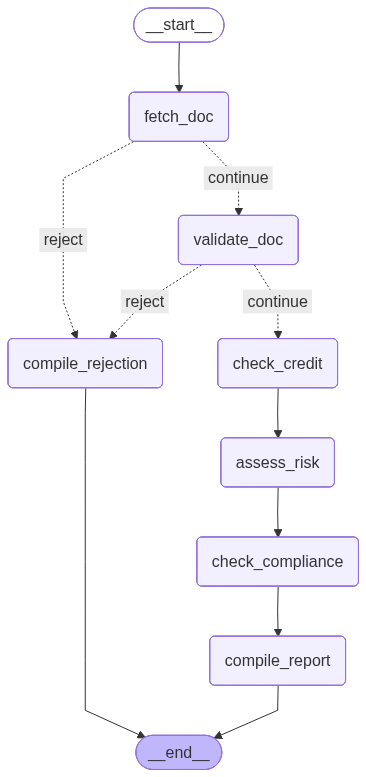

In [ ]:
#@title 2.3: Define and Compile the Graph
from langgraph.graph import StateGraph, END

# Define the graph builder
workflow = StateGraph(LoanGraphState)

# Add the nodes to the graph
workflow.add_node("fetch_doc", node_fetch_document)
workflow.add_node("validate_doc", node_validate_document)
workflow.add_node("check_credit", node_check_credit)
workflow.add_node("assess_risk", node_assess_risk)
workflow.add_node("check_compliance", node_check_compliance)
workflow.add_node("compile_report", node_compile_report)
workflow.add_node("compile_rejection", node_compile_rejection)

# Set the Entry Point
workflow.set_entry_point("fetch_doc")

# --- Define the Edges ---

# 1. Edge after fetching document
def after_fetch_decide(state: LoanGraphState):
   if state.get("error") or not state.get("document_content"):
      return "reject" # Go straight to rejection if fetch failed
   else:
      return "continue"

workflow.add_conditional_edges(
    "fetch_doc",
    after_fetch_decide,
    {
        "continue": "validate_doc",
        "reject": "compile_rejection"
    }
)

# 2. CONDITIONAL edge after document validation
def should_proceed_after_validation(state: LoanGraphState):
    if state.get("error"):
       return "reject"
    doc_status = state.get("document_status", "")
    if "FAILED" in doc_status:
        print("  -> Routing to rejection based on document status.")
        return "reject"  # Go to early rejection node
    else:
        print("  -> Routing to credit check.")
        return "continue" # Go to credit check node

workflow.add_conditional_edges(
    "validate_doc",
    should_proceed_after_validation,
    {
        "continue": "check_credit",
        "reject": "compile_rejection"
    }
)

# 3. Add normal, linear edges for the main success path
workflow.add_edge("check_credit", "assess_risk")
workflow.add_edge("assess_risk", "check_compliance")
workflow.add_edge("check_compliance", "compile_report")

# 4. Define the end points for the two possible final nodes
workflow.add_edge("compile_report", END)
workflow.add_edge("compile_rejection", END)

# Compile the graph into a runnable application
try:
   app = workflow.compile()
   print("LangGraph Compiled Successfully!")

   # Optional: Visualize the graph (requires !pip install pillow pygraphviz)
   try:
       from IPython.display import Image, display
       display(Image(app.get_graph().draw_mermaid_png()))
   except Exception as e:
       print(f"\nGraph visualization failed (optional libraries might be missing): {e}")

except Exception as e:
   print(f"Error compiling LangGraph: {e}")
   app = None

### Step 4: Run the Graph

Now we can test our graph with both valid and invalid data to see the conditional logic in action.

In [ ]:
#@title 2.4: Run the LangGraph Workflow

if app is None:
    print("LangGraph app not compiled due to errors. Skipping execution.")
else:
    # --- Test 1: Run with valid data ---
    print("\n--- LANGGRAPH RUN 1: VALID DOCUMENT ---")
    inputs_valid = {
        "applicant_id": "borrower_good_780",
        "document_id": "document_valid_123",
        # "messages": [] # Include if messages are part of state
    }

    print("Streaming intermediate steps:")
    for s_chunk in app.stream(inputs_valid, {"recursion_limit": 10}):
        # Print node name and the updated state keys
        step_name = list(s_chunk.keys())[0]
        step_output = s_chunk[step_name]
        print(f" Step: {step_name}, Updated State Keys: {list(step_output.keys())}")
        # print(f"   Output: {step_output}") # Uncomment for full output detail
        print("--- Next ---")

    # Invoke again to get the final result easily
    print("Invoking for final state...")
    final_state_valid = app.invoke(inputs_valid, {"recursion_limit": 10})
    print("\n--- LANGGRAPH FINAL REPORT (VALID) --- Check `final_decision` key below:")
    # print(final_state_valid) # Print the full final state
    print(final_state_valid.get('final_decision', 'Final decision not found in state.'))


    # --- Test 2: Run with INVALID data ---
    print("\n\n--- LANGGRAPH RUN 2: INVALID DOCUMENT ---")
    inputs_invalid = {
        "applicant_id": "borrower_bad_620",
        "document_id": "document_invalid_456",
        # "messages": []
    }

    print("Streaming intermediate steps:")
    for s_chunk in app.stream(inputs_invalid, {"recursion_limit": 10}):
        step_name = list(s_chunk.keys())[0]
        step_output = s_chunk[step_name]
        print(f" Step: {step_name}, Updated State Keys: {list(step_output.keys())}")
        # print(f"   Output: {step_output}")
        print("--- Next ---")

    print("Invoking for final state...")
    final_state_invalid = app.invoke(inputs_invalid, {"recursion_limit": 10})
    print("\n--- LANGGRAPH FINAL REPORT (INVALID) --- Check `final_decision` key below:")
    # print(final_state_invalid)
    print(final_state_invalid.get('final_decision', 'Final decision not found in state.'))


--- LANGGRAPH RUN 1: VALID DOCUMENT ---
Streaming intermediate steps:
--- NODE: Fetching Document ---
--- HELPER: Simulating fetch for doc_id: document_valid_123 ---
 Step: fetch_doc, Updated State Keys: ['document_content']
--- Next ---
--- NODE: Validating Document ---
--- TOOL: Validating document fields ---
  -> validated
  -> Routing to credit check.
 Step: validate_doc, Updated State Keys: ['validation_status', 'customer_id', 'loan_amount', 'income', 'credit_history']
--- Next ---
--- NODE: Checking Credit ---
--- TOOL: Calling Credit Bureau API for customer: CUST-12345 ---
  -> Credit Score: 810
 Step: check_credit, Updated State Keys: ['credit_score']
--- Next ---
--- NODE: Assessing Risk (LLM-Powered) ---
  -> LLM Assessment: Justification: The applicant exhibits excellent creditworthiness with a high credit score, a substantial income relative to the loan amount, and a solid credit history.
Risk: LOW
 Step: assess_risk, Updated State Keys: ['risk_score']
--- Next ---
--- NOD